# Wzbogacanie danych i przenoszenie uczenia
Wraz ze wzrostem liczby parametrów sieci problemem na powrót stał się brak danych. Występował on wcześniej, min. przy sieciach gęstych, gdzie, aby nauczyć takie rozwiązanie potrzeba było podczas treningu podać niemalże wszystkie możliwe kombinacje danych. Wtedy rozwiązaniem okazało się wprowadzenie sieci splotowych, w których perceptrony zgromadzono w przesuwające się po danych wejściowych oknach, dzięki temu stało się możliwe wykorzystywanie tych samych wyuczonych elementów w stosunku do dowolnego fragmentu obrazu.

Nowe podejście do wspomnianego problemu jest realizowane dwutorowo. Po pierwsze generuje się dodatkowe obrazy, na podstawie tych już istniejących w zbiorze, dzięki czemu algorytm ma więcej informacji o tym, które cech sa istotne, a które nie. Te elementy, które w dodanych obrazach pozostają niezmienne, klasyfikator traktuje jako istotne, natomiast te, które się zmieniają, ignoruje. Drugim sposobem jest kopiowanie wyuczonych fragmentów sieci, co jest możliwe, dzięki temu, że część zdolności, które musi nabyć klasyfikator, jest w dużej mierze niezależna od konkretnego problemu. Z drugiej strony te zdolności często wymagają sporej ilości obliczeń i danych przy treningu, co daje dodatkowe korzyści, a w niektórych przypadkach, w szczególności, gdy występuje problem braku wystarczającej liczby różnorodnych przykładów, w ogóle umożliwia skuteczny trening.

Jeden z tego typu problemów jest przedmiotem niniejszego ćwiczenia. Zbiór Fashion-MNIST zawiera dużą liczbę, w zbliżony sposób wykonanych fotografii. Jest to stosunkowo łatwy zbiór do osiągnięcia na nim wysokiej skuteczności, nawet dla małych sieci typu LeNet-5, ale z powodu na niską różnorodność, wytrenowane na nim modele słabo adaptują się do obrazów naturalnych. Aby zaradzić temu problemowi, w niniejszym ćwiczeniu wykorzystano wagi wyliczone na podstawie zbioru ImageNet. W związku z tym głównym wyzwaniem pozostaje takie dostosowanie klasyfikatora do nowego problemu, aby nie utracić wcześniej nabytych zdolności.

## Zależności

In [1]:
import numpy as np
import time

import PIL.Image as Image
import PIL.ImageOps    
import matplotlib.pylab as plt

import tensorflow as tf
import tf_keras as keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from keras import datasets

import datetime
import os

%load_ext tensorboard

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-06-30 21:23:33.722235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 21:23:33.722296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 21:23:33.765533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 21:23:33.871484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 21:23:36.427502: W tensorflow/compiler/tf2

2.15.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-30 21:23:41.368453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 21:23:41.750188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 21:23:41.750972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Klasyfikator ImageNet
### Pobranie klasyfikatora

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnet_v1 = "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/50-classification/2"

classifier_model = inception_v3

In [35]:
IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

classifier = keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Uruchomienie klasyfikatora na pojedyńczym obrazie

211086/211086 [==============================] - 0s 0us/step


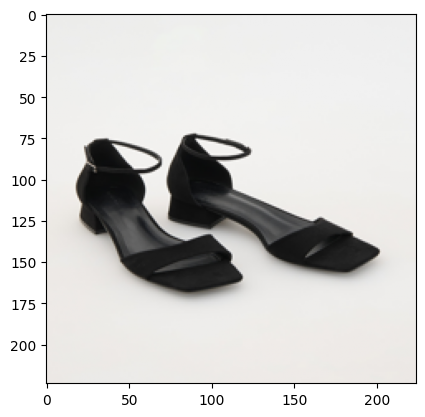

(224, 224, 3)

In [94]:
path = keras.utils.get_file('image.jpg','https://static.reserved.com/media/catalog/product/5/6/5698Y-99X-011-1-808148.jpg')

img = np.array( Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE)) ) / 255.0
os.remove(path)
plt.figure()
plt.imshow(img)
plt.grid(False)
plt.show()
img.shape


In [95]:
result = classifier.predict(img[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 31ms/step


(1, 1001)

In [96]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=789>

### Dekodowanie predykcji

In [97]:
labels_path = keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

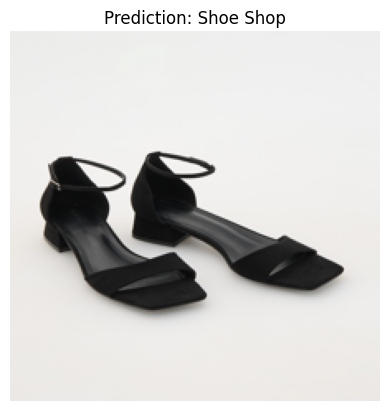

In [98]:
plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Import i wstępne przygotowanie danych

In [85]:
class ImgAug(keras.layers.Layer):      
  def call(self, img):
    offset=int((IMAGE_SIZE-img.shape[0])/2)
    return tf.image.grayscale_to_rgb(
        tf.image.pad_to_bounding_box(img, offset, offset, IMAGE_SIZE, IMAGE_SIZE)
    )

resize_and_rescale = tf.keras.Sequential([
 #keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 keras.layers.Rescaling(1./255),
 ImgAug()
])

In [86]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'fashion_mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True)
test_ds = prepare(test_ds)

num_classes = metadata.features['label'].num_classes
print(num_classes)

10


224


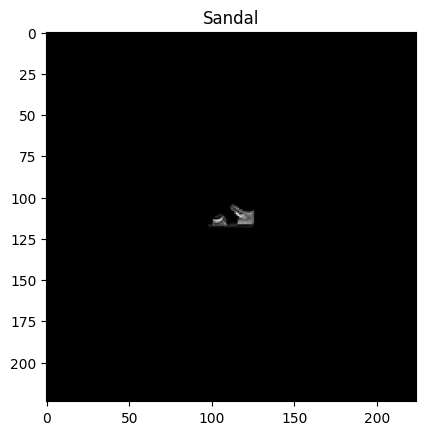

In [100]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(test_ds))
_ = plt.imshow(image[0])
_ = plt.title(get_label_name(label[0]))
print(image[0].shape[0])

In [99]:
result = classifier.predict(test_ds)

188/188 [==============================] - 101s 537ms/step


## Trening modelu

## Zadania
1. Dodaj modyfikacje danych treningowych polegające na losowych zmianach rozmiaru i położenia. (1 pkt)
2. W zbiorze treningowym Fashion-MNIST wszystkie obrazy są monochromatyczne. Wzbogać je o kolory. (1 pkt)
3. Wybierz z Internetu co najmniej kilka fotografii, należących do klas ze zbioru Fasion-MNIST, zbuduj z nich niewielki zbiór i sprawdź na nim rezultaty uczenia ze wzbogacaniem danych i bez niego. Zadbaj, aby znalazły się w nim zarówno przykłady należące do klas, które mają swoją reprezentację w obu zbiorach (ImageNet2012 i Fashion-MNIST) jak sandal, T-shirt jak też take, które występują tylko w Fashion-MNIST. (3 pkt)

## Źródła
[Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
